# K- Nearest Neighbors on Amazon Food Reviews

In [59]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# General Packages
import os
import sqlite3
import pandas as pd
import numpy as np
import string
import re
import nltk
import datetime
import time
from decimal import *

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for BOW (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Packages for Text Preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Packages for Word2vec, Average Word2vec & Tf-Idf Weighted Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Packages for plotting Tsne plot
from sklearn.manifold import TSNE

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import TimeSeriesSplit
from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score
from sklearn.decomposition import TruncatedSVD

In [60]:
# Formaing Output using pretty table
Pretty = PrettyTable(["Model","Algorithm"," K ","TPR","TNR","Precision","Recall","F1-Score","FPR","FNR","PPV","NPV","Overall Accuracy (ACC)"])
Pretty.set_style(MSWORD_FRIENDLY)
print(Pretty)

| Model | Algorithm |  K  | TPR | TNR | Precision | Recall | F1-Score | FPR | FNR | PPV | NPV | Overall Accuracy (ACC) |


### Preprocessing Stage: Cleansed Stop Words, Punctuations & Html tags

In [61]:
#Connecting the Sqlite file after the Preprocessing Stage
#os.chdir('/Users/sujis/Downloads/AI/Sujit')
os.chdir('C:\Users\sujit.venkata\Downloads\Dev & Imp works\Applied AI')
con = sqlite3.connect('final.sqlite') 
final= pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [62]:
final.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [63]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### Taking a Sample of 75000 records from the Dataset

In [64]:
# Taking 75K data points from the dataset
final_dataset=final.head(75000)

In [65]:
final_dataset['Score'].value_counts()

positive    63939
negative    11061
Name: Score, dtype: int64

In [66]:
#Sorting the Dataframe with Date to apply Timebased Split
final_dataset=final_dataset.sort_values(by='Time',ascending=1)

In [67]:
# create design matrix X and target vector y
X = np.array(final_dataset.iloc[:, 0:12]) # end index is exclusive
Y = np.array(final_dataset['Score']) # showing you two ways of indexing a pandas df

In [68]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(n_splits=5)


In [69]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   Y_train, Y_test = Y[train_index], Y[test_index]

('TRAIN:', array([    0,     1,     2, ..., 12497, 12498, 12499], dtype=int64), 'TEST:', array([12500, 12501, 12502, ..., 24997, 24998, 24999], dtype=int64))
('TRAIN:', array([    0,     1,     2, ..., 24997, 24998, 24999], dtype=int64), 'TEST:', array([25000, 25001, 25002, ..., 37497, 37498, 37499], dtype=int64))
('TRAIN:', array([    0,     1,     2, ..., 37497, 37498, 37499], dtype=int64), 'TEST:', array([37500, 37501, 37502, ..., 49997, 49998, 49999], dtype=int64))
('TRAIN:', array([    0,     1,     2, ..., 49997, 49998, 49999], dtype=int64), 'TEST:', array([50000, 50001, 50002, ..., 62497, 62498, 62499], dtype=int64))
('TRAIN:', array([    0,     1,     2, ..., 62497, 62498, 62499], dtype=int64), 'TEST:', array([62500, 62501, 62502, ..., 74997, 74998, 74999], dtype=int64))


In [70]:
print(X_train.shape)
print(X_test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(62500L, 12L)
(12500L, 12L)
-------------------
(62500L,)
(12500L,)


In [71]:
# Converting X_Train, X_cv & X_test data is  to Dataframe for the ease of use
X_train_data=pd.DataFrame(X_train, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_test_data=pd.DataFrame(X_test, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 


## Bag of Words

In [72]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(X_train_data['CleanedText'].values)
# Bag of Words : Train Data Set
Train_X_vector = vectorizer.transform(X_train_data['CleanedText'].values)
# summarize encoded vector
print(Train_X_vector.shape)

(62500, 30110)


In [73]:
#Test Data Set
Test_X_vector = vectorizer.transform(X_test_data['CleanedText'].values)
print(Test_X_vector.shape)

(12500, 30110)


In [74]:
print(Train_X_vector.shape)
print(Test_X_vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(62500, 30110)
(12500, 30110)
-------------------
(62500L,)
(12500L,)


In [75]:
# 10 fold Cross Validation
cv_scores=[]
Params = list(np.arange(0.1,1,0.01))

for a in Params:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, Train_X_vector, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

In [76]:
# determining best k
optimal_alpha = Params[MSE.index(min(MSE))]
print('\nThe optimal alpha is %0.3f' % optimal_alpha)


The optimal alpha is 0.990


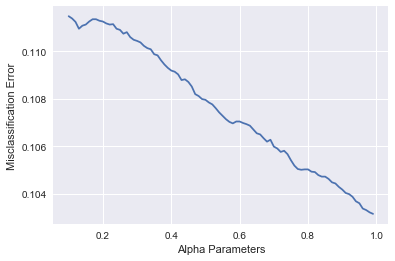

('the misclassification error for each Alpha value is : ', array([ 0.1115,  0.1114,  0.1112,  0.1109,  0.1111,  0.1111,  0.1112,
        0.1113,  0.1113,  0.1113,  0.1112,  0.1112,  0.1111,  0.1111,
        0.1109,  0.1109,  0.1107,  0.1108,  0.1106,  0.1105,  0.1104,
        0.1104,  0.1102,  0.1101,  0.1101,  0.1099,  0.1098,  0.1096,
        0.1094,  0.1093,  0.1092,  0.1091,  0.109 ,  0.1088,  0.1088,
        0.1087,  0.1085,  0.1082,  0.1081,  0.108 ,  0.108 ,  0.1078,
        0.1078,  0.1076,  0.1074,  0.1073,  0.1071,  0.107 ,  0.107 ,
        0.107 ,  0.107 ,  0.107 ,  0.1069,  0.1069,  0.1067,  0.1065,
        0.1065,  0.1063,  0.1062,  0.1063,  0.106 ,  0.1059,  0.1058,
        0.1058,  0.1057,  0.1054,  0.1052,  0.105 ,  0.105 ,  0.105 ,
        0.105 ,  0.1049,  0.1049,  0.1048,  0.1047,  0.1047,  0.1046,
        0.1045,  0.1044,  0.1043,  0.1042,  0.104 ,  0.104 ,  0.1039,
        0.1037,  0.1036,  0.1034,  0.1033,  0.1032,  0.1032]))


In [77]:
# plot misclassification error vs k 
plt.plot(Params, MSE)

plt.xlabel('Alpha Parameters')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,4))


In [78]:
nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(Train_X_vector,Y_train)
pred = nb.predict(Test_X_vector)
nb.predict_proba(Test_X_vector)
bag_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\nThe accuracy of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f%%' % (optimal_alpha, bag_test_acc))
#print('\n****Test accuracy for Alpha = 0.990 is %0.2f%%' % (bag_test_acc))


The accuracy of the Naive Bayes Classifier for Alpha = 0.990 is 85.10%


In [79]:
# Getting top Features using feature_log_prob
neg=np.take(vectorizer.get_feature_names(), (nb.feature_log_prob_[0, :].argsort())[:20]).tolist()
pos=np.take(vectorizer.get_feature_names(), (nb.feature_log_prob_[1, :].argsort())[:20]).tolist()

In [80]:
# Getting top Features using feature_count
def takefeature(elem):
    return elem[0]
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),key=takefeature,reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),key=takefeature,reverse=True)[:n]
    return topn_class1,topn_class2

In [81]:
neg_bw,pos_bw=important_features(vectorizer,nb,n=20)

In [82]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [83]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

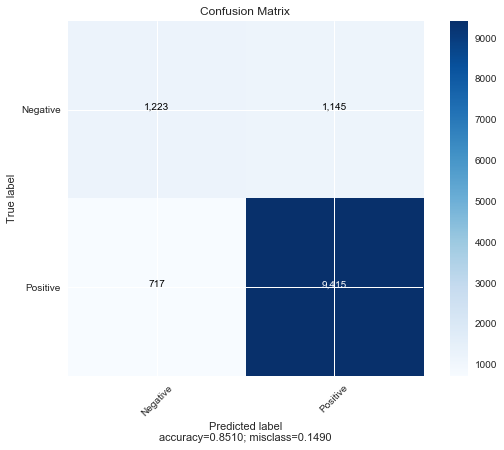

In [84]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [85]:
Conf_matrix

array([[1223, 1145],
       [ 717, 9415]])

In [86]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [87]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(Decimal(TP)/Decimal(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(Decimal(TN)/Decimal(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(Decimal(FP)/Decimal(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(Decimal(FN)/Decimal(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(Decimal(TP)/Decimal(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(Decimal(TN)/Decimal(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format(Decimal(TP+TN)/Decimal(TP+FP+FN+TN))

In [88]:
Recall=recall_score(Y_test, pred, average='micro') 

In [89]:
Precision=precision_score(Y_test, pred, average='micro')

In [90]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [91]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,1223,1145,2368
positive,717,9415,10132
All,1940,10560,12500


In [92]:
Pretty.add_row(["Bag of Words","10 fold - Cross Validation",optimal_alpha,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [93]:
print(Pretty)

|    Model     |         Algorithm          |  K   |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
| Bag of Words | 10 fold - Cross Validation | 0.99 | 92.92% | 51.65% |    0.85   |  0.85  |   0.85   | 48.35% | 7.08% | 89.16% | 63.04% |         85.10%         |


In [94]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.63      0.52      0.57      2368
   positive       0.89      0.93      0.91     10132

avg / total       0.84      0.85      0.85     12500



## TF - IDF

In [95]:
tf_transformer = TfidfVectorizer(ngram_range=(1,2))
TF_vector=tf_transformer.fit(X_train_data['CleanedText'].values)
TF_train_Vector = TF_vector.transform(X_train_data['CleanedText'].values)
TF_train_Vector.shape

(62500, 885097)

In [96]:
TF_test_Vector = TF_vector.transform(X_test_data['CleanedText'].values)
TF_test_Vector.shape

(12500, 885097)

In [97]:
print(TF_train_Vector.shape)
print(TF_test_Vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(62500, 885097)
(12500, 885097)
-------------------
(62500L,)
(12500L,)


In [98]:
# 10 fold Cross Validation
cv_scores=[]
Params = list(np.arange(0.1,1,0.01))

for a in Params:
    nb = MultinomialNB(alpha=a)
    scores = cross_val_score(nb, TF_train_Vector, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

In [99]:
# determining best k
optimal_alpha = Params[MSE.index(min(MSE))]
print('\nThe optimal alpha is %0.3f' % optimal_alpha)


The optimal alpha is 0.100


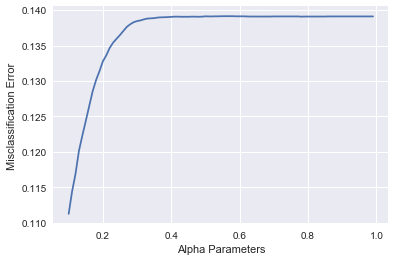

('the misclassification error for each Alpha value is : ', array([ 0.1113,  0.1144,  0.1169,  0.1201,  0.1223,  0.1244,  0.1264,
        0.1285,  0.1301,  0.1314,  0.1328,  0.1336,  0.1347,  0.1354,
        0.136 ,  0.1365,  0.1371,  0.1376,  0.138 ,  0.1383,  0.1384,
        0.1385,  0.1387,  0.1388,  0.1388,  0.1389,  0.1389,  0.139 ,
        0.139 ,  0.139 ,  0.139 ,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391,
        0.1391,  0.1391,  0.1391,  0.1391,  0.1391,  0.1391]))


In [100]:
# plot misclassification error vs k 
plt.plot(Params, MSE)

plt.xlabel('Alpha Parameters')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,4))


In [101]:
nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(TF_train_Vector,Y_train)
pred = nb.predict(TF_test_Vector)
nb.predict_proba(TF_test_Vector)
bag_test_acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\nThe accuracy of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f%%' % (optimal_alpha, bag_test_acc))


The accuracy of the Naive Bayes Classifier for Alpha = 0.100 is 88.02%


In [102]:
# Getting top Features using feature_log_prob
neg=np.take(tf_transformer.get_feature_names(), (nb.feature_log_prob_[0, :].argsort())[:20]).tolist()
pos=np.take(tf_transformer.get_feature_names(), (nb.feature_log_prob_[1, :].argsort())[:20]).tolist()

In [103]:
# Getting top Features using feature_count
def takefeature(elem):
    return elem[0]
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),key=takefeature,reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),key=takefeature,reverse=True)[:n]
    return topn_class1,topn_class2

In [104]:
neg_tf,pos_tf=important_features(tf_transformer,nb,n=20)

In [105]:
Conf_matrix=confusion_matrix(Y_test, pred)

In [106]:
Conf_matrix

array([[1049, 1319],
       [ 179, 9953]])

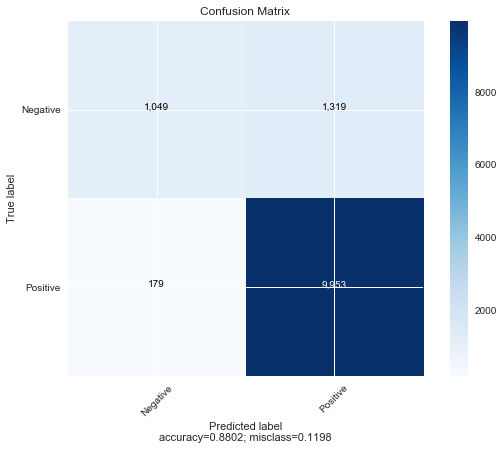

In [107]:
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [108]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [109]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(Decimal(TP)/Decimal(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(Decimal(TN)/Decimal(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(Decimal(FP)/Decimal(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(Decimal(FN)/Decimal(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(Decimal(TP)/Decimal(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(Decimal(TN)/Decimal(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format(Decimal(TP+TN)/Decimal(TP+FP+FN+TN))

In [110]:
Recall=recall_score(Y_test, pred, average='micro') 

In [111]:
Precision=precision_score(Y_test, pred, average='micro')

In [112]:
F1_Score=f1_score(Y_test, pred, average='weighted')

In [113]:
pd.crosstab(Y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,1049,1319,2368
positive,179,9953,10132
All,1228,11272,12500


In [114]:
Pretty.add_row(["TF - IDF","10 fold - Cross Validation",optimal_alpha,TPR,TNR,'{0:.2f}'.format(Precision),'{0:.2f}'.format(Recall),'{0:.2f}'.format(F1_Score),FPR,FNR,PPV,NPV,ACC])

In [115]:
print(classification_report(Y_test, pred))  

             precision    recall  f1-score   support

   negative       0.85      0.44      0.58      2368
   positive       0.88      0.98      0.93     10132

avg / total       0.88      0.88      0.86     12500



In [116]:
print(Pretty)

|    Model     |         Algorithm          |  K   |  TPR   |  TNR   | Precision | Recall | F1-Score |  FPR   |  FNR  |  PPV   |  NPV   | Overall Accuracy (ACC) |
| Bag of Words | 10 fold - Cross Validation | 0.99 | 92.92% | 51.65% |    0.85   |  0.85  |   0.85   | 48.35% | 7.08% | 89.16% | 63.04% |         85.10%         |
|   TF - IDF   | 10 fold - Cross Validation | 0.1  | 98.23% | 44.30% |    0.88   |  0.88  |   0.86   | 55.70% | 1.77% | 88.30% | 85.42% |         88.02%         |


In [120]:
print 'Top 20 Impotant Positive Features Identied using feature_count_'

Top 20 Impotant Positive Features Identied using feature_count_


In [161]:
Features = pd.DataFrame({'Class':[],'Model':[],'Feature Counts' : [], 'Feature':[]})
for each in pos_bw:
    Features = Features.append({'Class':'Positive','Model':'Bag of Words','Feature Counts': each[0],'Feature':each[1]}, ignore_index=True) 
for each in neg_bw:
    Features = Features.append({'Class':'Negative','Model':'Bag of Words','Feature Counts': each[0],'Feature':each[1]}, ignore_index=True) 
for each in pos_tf:
    Features = Features.append({'Class':'Positive','Model':'TF - IDF','Feature Counts': each[0],'Feature':each[1]}, ignore_index=True) 
for each in pos_tf:
    Features = Features.append({'Class':'Negative','Model':'TF - IDF','Feature Counts': each[0],'Feature':each[1]}, ignore_index=True) 

In [162]:
Features

,Class,Feature,Feature Counts,Model
0,Positive,like,15110.0,Bag of Words
1,Positive,tast,14851.0,Bag of Words
2,Positive,love,14716.0,Bag of Words
3,Positive,great,14525.0,Bag of Words
4,Positive,good,14238.0,Bag of Words
5,Positive,use,12339.0,Bag of Words
6,Positive,one,11805.0,Bag of Words
7,Positive,flavor,11427.0,Bag of Words
8,Positive,product,10955.0,Bag of Words
9,Positive,tri,10884.0,Bag of Words


In [163]:
Features.to_csv('Features.csv',index=None)

## Conclusion

We can conclude that the "TF-IDF Vectorized Multinomial Naive Bayes Classifier" achieved significantly good Precision and Probability rates & TPR,TNR  compared to "Bag of Words Vectorized Multinomial Naive Bayes Classifier".